# Clock Data Processing and Interpolation Report 

By Suzanne Thornton (776) 

This report covers the data processing steps, including interpolation, that are necessary to obtain a time series of clock ratios. We use examples of data collected in 2025. To obtain a clock ratio series, we assume there are shift data files corresponding to each clock in the ratio and a deglitched optical frequency comb data file. We use Python to process, format, and analyse the data. 

## Import and Setup

First, import the following Python packages.

In [1]:
#############################  Load packages #######################################
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
import math 
from astropy.time import Time
import missingno as msno

Then define functions to extract and load the comb data and each of the shift data files into the workspace. Note the last function in this section extracts information for the maser corrections. In this report, we restrict our attention to the ErYb comb. The process for the Ti Sapphire comb is similar but will require a different open comb file function. 

In [2]:
#############################  Load data #######################################
def open_ErYb_data(data_path):
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Yb_ErYb", "fb_Al_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    data.index = range(len(data))
 
    return data[list(types.keys())]

def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data

def open_shiftfile_Sr(datapath):
    data = pd.read_csv(datapath, header=24, delimiter="\t", dtype={1: str}, engine="python")

    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t",  dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
def open_maser_correction(datapath):
    data = pd.read_csv(datapath, header=1, delimiter=",", dtype={1: str}, engine="python")
 
    data.columns = ["date", "maser_offset"]
 
    data["date"] = data["date"].str.split("-").str.join("")
    data["maser_offset"] = data["maser_offset"].apply(float)
 
    return data

For this report, we make use of data that spans several different days of data collection. The list `days` contains the dates for which we have complete data available for analysis. After setting the path to the folder containing the data files, we can now load the maser corrections data, the comb data, and the shift data into the workspace. 

In [3]:
days = [20250116, 20250124, 20250204, 20250227, 20250304, 20250307, 20250318]
days = list(map(str, days))
day_index = 6
path = "/Users/smt3/Documents/GitHub/2025 clock comparison data/"

maser_corrections = open_maser_correction(path + "daily maser offsets.csv")
data_ErYb = open_ErYb_data(path + days[day_index] + "/" + days[day_index] + "_Deglitched_ErYb_only.dat") 
shift_data_Al = open_shiftfile_Al(path + days[day_index] + "/" + days[day_index] + "_Alp_Freq_Shifts_ErYb.dat")
shift_data_Sr = open_shiftfile_Sr(path + days[day_index] + "/" + days[day_index] + "_clock_lock0.dat")
shift_data_Yb = open_shiftfile_Yb(path + days[day_index] + "/YbI_1_rerun.txt")

Next, we define functions that compute the optical frequecies for each clock based on the comb equation. We then apply these functions to the comb data object defined in the last step, i.e. `data_ErYb`. (If using the Ti Sapphire comb, these functions will need to be rewritten.) 

In [4]:
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

def compute_nuSr_ErYb(data):
    data["nuSi"] = -Decimal("105e6") + Decimal("388752") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - Decimal("100e6")
    data["nuSr"] = (Decimal("1716882") / Decimal("777577")) * (data["nuSi"] - Decimal("216e6"))

def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"] 

compute_nuAl_ErYb(data_ErYb)
compute_nuSr_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb) 

Part of the data processing steps is to ensure that all values are read as high precision decimal values. We ensure that the constants involved in the calculation of the ratio offset time series are all *Decimal* objects in Python. This includes each of the previous ratio averages to which we compare the current data's offset, the maser correction, and the gravitational shift corrections. The total correction factors are computed for each of the three clocks. 

In [5]:
YbSrRatio2020 = Decimal("1.2075070393433378482") 
AlYbRatio2020 = Decimal("2.162887127516663703")
AlSrRatio2020 = Decimal("2.611701431781463025")
 
correction_condition = days[day_index] == maser_corrections["date"]
masercorrection = maser_corrections[correction_condition]["maser_offset"].apply(Decimal)

GR_shift_Al = Decimal("-8.114e-16") 
GR_shift_Yb = Decimal("-8.109e-16")
GR_shift_Sr = Decimal("10.660e-16")
GR_shift_sea_level = Decimal("-1798.501e-16")

total_correction_Yb = Decimal("1") + GR_shift_Yb + GR_shift_sea_level + masercorrection
total_correction_Sr = Decimal("1") + GR_shift_Sr + GR_shift_sea_level + masercorrection
total_correction_Al = Decimal("1") + GR_shift_Al + GR_shift_sea_level + masercorrection

To complete the data import and analysis set up, we define the following function to compute the overlapping Alan variance of a time series of high precision decimals. The first argument of this function, `y`, is the time series, and the argument `m` is a whole number representing the window size over which to calculate the Alan variance. 

In [6]:
def overlapping_avar_fn(y, m): 
    M = len(y)

    if M < 2 * m:
        raise ValueError(f"Length of input (M={M}) must be at least 2 * m (2 * {m} = {2 * m})")

    if any(isinstance(v, Decimal) and v.is_nan() for v in y):  
        raise ValueError("Input y contains NaN values.")
    
    if m <= 0:
        raise ValueError("m must be a positive integer")

    outer_sum = 0

    for j in range(0, M - 2 * m + 1):
        inner_sum = 0
        for i in range(j, j + m):
            inner_sum += y[i + m] - y[i]
        outer_sum += inner_sum ** 2

    result = outer_sum / (2 * m**2 * (M - 2 * m + 1))
    return result

## Data Processing 

### Visualizing Missing Values 
Data visualization is an important step to identify any unexpected patterns, including patterns of missing data. It is crucial that the individual time series used to compute the end result (a time series of ratio offsets) are visualized before they are combined and analyzed. This step also helps with the determination of an overlapping window of observations, discussed in the last subsection. 

First we take a look at the (three) time series corresponding to individual clock frequencies calculated from the comb equation and data. The `missingno` package is useful here since each of these series corresponds to the same time index, i.e. the same MJD values. To use this package we must convert the data types to floats and then create a data Pandas data frame containing the MJD values and the comb frequency values corresponding to each clock (`nuAl`, `nuSr`, and `nnYb`). The spaces in the matrix of missingness plots represent missing values. Finally, we report the total number of missing values for each of the clock frequency series using the print statement.

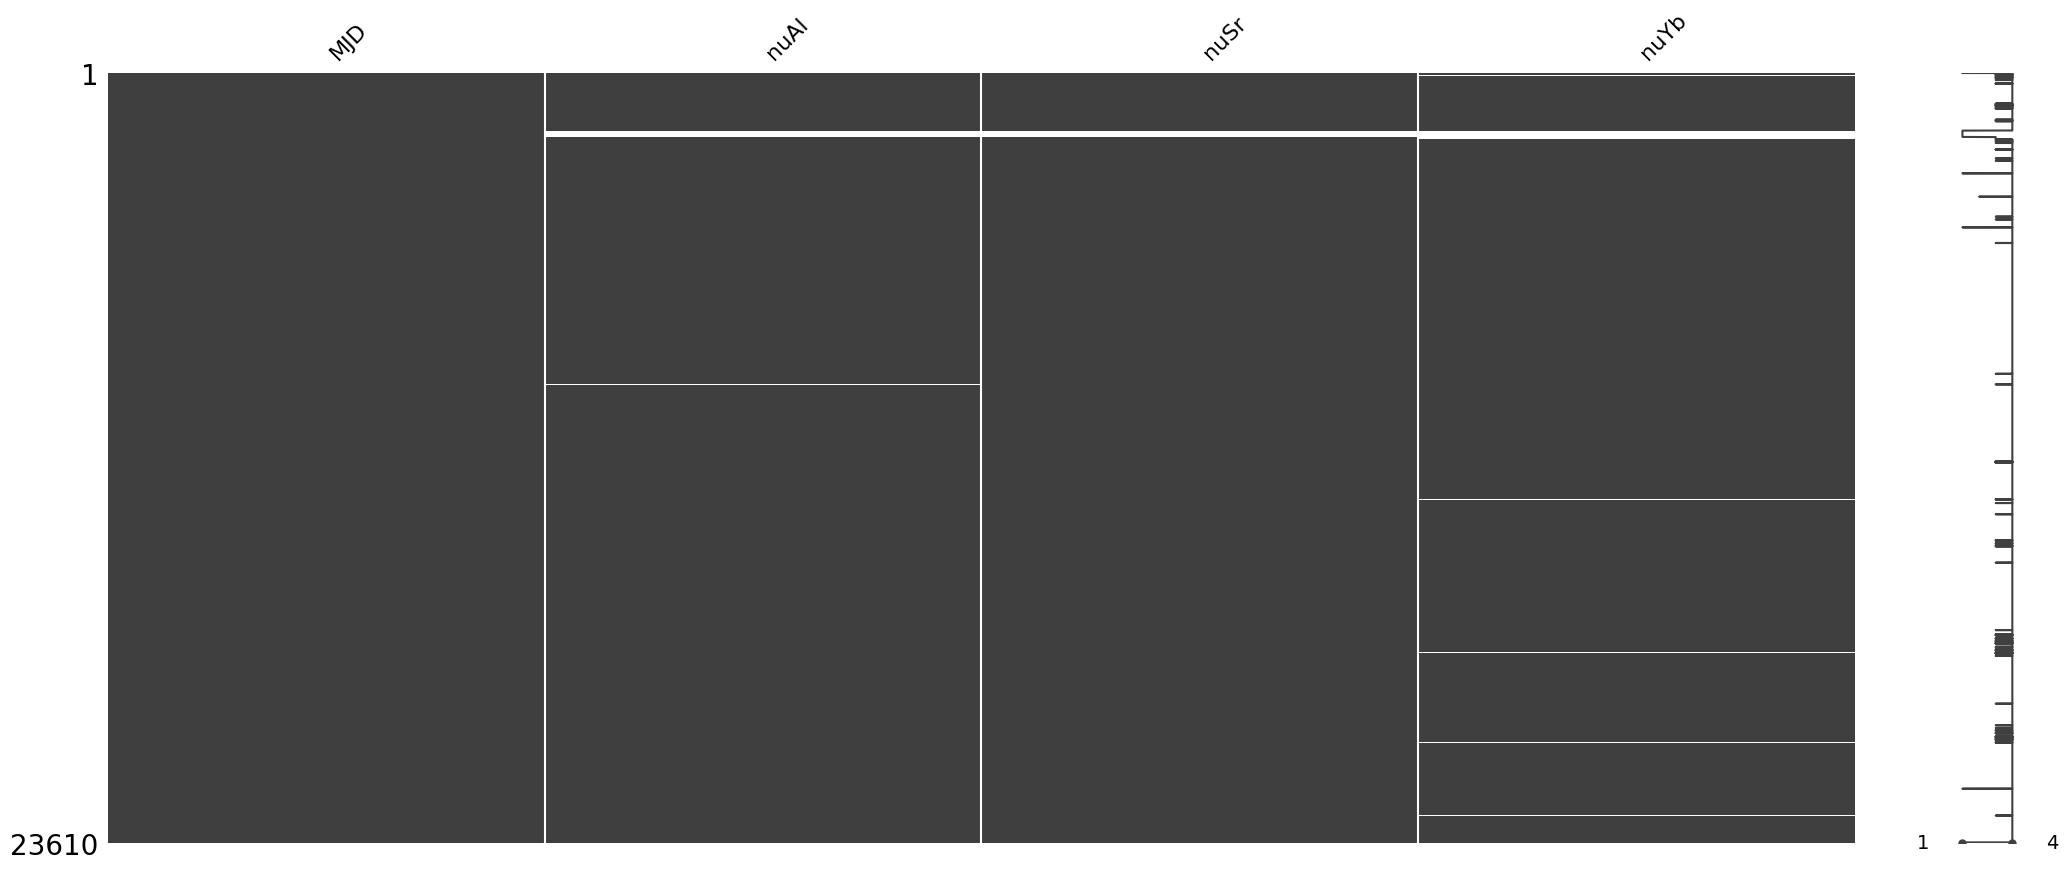

Missing Al comb nu:  233
Missing Sr comb nu:  203
Missing Yb comb nu:  417


In [10]:
common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuSr = data_ErYb["nuSr"].astype(float)
nuYb = data_ErYb['nuYb'].astype(float)

msno.matrix(pd.DataFrame({'MJD': common_mjd, 'nuAl': nuAl, 'nuSr': nuSr, 'nuYb': nuYb}))
plt.show()

print("Missing Al comb nu: ", nuAl.isna().sum())
print("Missing Sr comb nu: ", nuSr.isna().sum())
print("Missing Yb comb nu: ", nuYb.isna().sum())

Next, we proceed to visualizing the missing values for each of the shift series. The `missingno` package is not as useful here because each clock's shift data corresponds to a unique time index. Instead, we  visualize the MJD indicies corresponding to each  clock's shift data along with the MJD indicies corresponding to non-missing comb frequecy values. 

In the code below, we use boolean indexing to extract a series of MJD values that correspond to non-missing clock shift values. We do the same thing for the comb data only here, the boolean condition checks that each of the clock comb frequency values (i.e. `nuAl`, `nuSr`, and `nuYb`) are non-missing. In the plot below, the default point size was decreased to make it easier to see any gaps or divets where the data is missing. As we did with the comb data, we report the total number of missing values for each of shift series using the print statement.

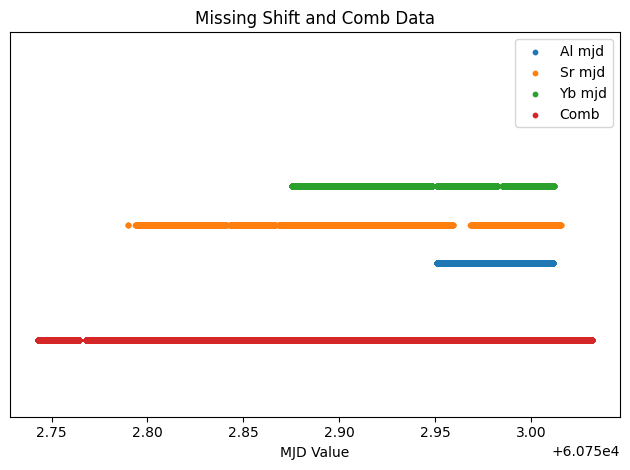

NA Al shift values:  81164
NA Sr shift values:  0
NA Yb shift values:  515


In [15]:
al_cond = ~shift_data_Al['shift'].isna()
Al_non_na = shift_data_Al[al_cond]
Al = pd.Series(Al_non_na['MJD'])

sr_cond = ~shift_data_Sr['shift'].isna()
Sr_non_na = shift_data_Sr[sr_cond]
Sr = pd.Series(Sr_non_na['MJD'])

yb_cond = ~shift_data_Yb['shift'].isna()
Yb_non_na = shift_data_Yb[yb_cond]
Yb = pd.Series(Yb_non_na['MJD']) 

comb_condition = (~data_ErYb['nuAl'].isna() & ~data_ErYb['nuSr'].isna() & ~data_ErYb['nuYb'].isna())
comb_full = data_ErYb[comb_condition]

plt.figure()
plt.scatter(Al, pd.Series([1] * len(Al)), label = 'Al mjd', s=10)
plt.scatter(Sr, pd.Series([1.25] * len(Sr)), label = 'Sr mjd', s=10)
plt.scatter(Yb, pd.Series([1.5] * len(Yb)), label = 'Yb mjd', s=10)
plt.scatter(pd.Series(comb_full['MJD']), pd.Series([0.5] * len(comb_full['MJD'])), label = 'Comb', s=10)
plt.ylim(0,2.5)
plt.yticks([])
plt.title('Missing Shift and Comb Data')
plt.xlabel("MJD Value")
plt.legend()
plt.tight_layout()
plt.show()

print("NA Al shift values: ", shift_data_Al['shift'].isna().sum())
print("NA Sr shift values: ", shift_data_Sr['shift'].isna().sum())
print("NA Yb shift values: ", shift_data_Yb['shift'].isna().sum())

In the example above, we can visually detect gaps of missing data in each series except for the one corresponding the Al+ shift values (blue). However, looking at the numerical summaries, we can tell that the Al+ shift data contains the most missing values. This is because the recorded MJD values for this clock's shift data start much earlier than the recorded shift values. This can be understood as a large "gap" of missing data at the beginning and end of the recorded Al+ shift values. 

### Extracting Quality Shift Data

The next step in the data processing stage is to ensure that we are only using shift values that are deemed quality data by the clock scientist. Each of the clock shift data files contains a column labeled `IS_GOOD` which indicates whether or not there was an issue with the reading of the data (0 indicates a known issue, 1 indicates no know issues). Based on the non-missing data for each clock's shift series, we further select a subset of each shift series that corresponds only to quality data. This may or may not decrease the number of points plotted in each of the clock's shift series. In this example, there is no visual change in the patterns of missing data. However, looking at the printed numerical summary, we now see that there are no detected missing (i.e. NaN) data points. This is because any missing data has been discarded from the "good" series. Thus even though there are no NaN or poor quality data included in these series, we can tell from the plot that there are still "gaps" in the MJD values for most series where there is no recorded data. These gaps are important to consider in the following subset and they also matter in the next section where we apply interpolation techniques.   

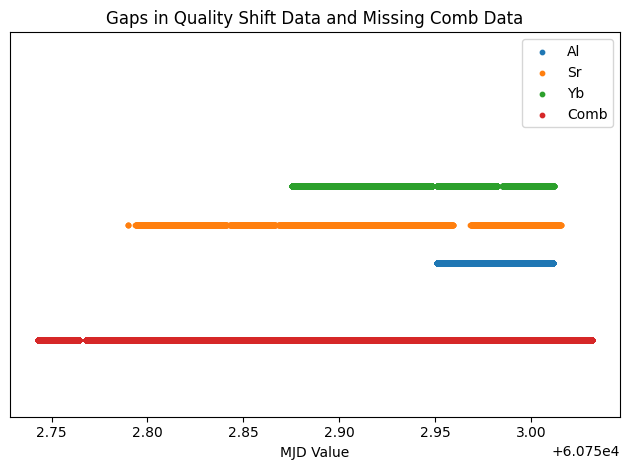

NA Al shift values:  0
NA Sr shift values:  0
NA Yb shift values:  0


In [ ]:
good_condition_al = Al_non_na["IS_GOOD"] == 1
shift_data_Al_good = Al_non_na[good_condition_al].reset_index(drop=True, inplace = False)
Al_good = pd.Series(shift_data_Al_good['MJD'])

good_condition_sr = Sr_non_na["IS_GOOD"] == 1
shift_data_Sr_good = Sr_non_na[good_condition_sr].reset_index(drop=True, inplace = False)
Sr_good = pd.Series(shift_data_Sr_good['MJD'])

good_condition_yb = Yb_non_na["IS_GOOD"] == 1
shift_data_Yb_good = Yb_non_na[good_condition_yb].reset_index(drop=True, inplace = False)
Yb_good = pd.Series(shift_data_Yb_good['MJD']) 

plt.figure()
plt.scatter(Al_good, pd.Series([1] * len(Al_good)), label = 'Al', s=10)
plt.scatter(Sr_good, pd.Series([1.25] * len(Sr_good)), label = 'Sr', s=10)
plt.scatter(Yb_good, pd.Series([1.5] * len(Yb_good)), label = 'Yb', s=10)
plt.scatter(pd.Series(comb_full['MJD']), pd.Series([0.5] * len(comb_full['MJD'])), label = 'Comb', s=10)
plt.ylim(0,2.5)
plt.yticks([])
plt.title('Gaps in Quality Shift Data and Missing Comb Data')
plt.xlabel("MJD Value")
plt.legend()
plt.tight_layout()
plt.show()

## Visualize missing shift values for each clock's "good" data   
print("NA Al shift values: ", shift_data_Al_good['shift'].isna().sum())
print("NA Sr shift values: ", shift_data_Sr_good['shift'].isna().sum())
print("NA Yb shift values: ", shift_data_Yb_good['shift'].isna().sum())

### Determination of an Overlapping Window of Observations

As we can see in the last plot of the previous section, each of the time series begins and ends at different MJD values. We confirm this with the following code which displays the exact start and end MJD values for each of the clock shift series and the comb MJD series. 

[Make comment about how can extract overlapping window per pair rather than overall]

In [ ]:
len_comb = len(comb_full['MJD']) 
len_Al = len(shift_data_Al_good['shift'])        
len_Sr = len(shift_data_Sr_good['shift'])        
len_Yb = len(shift_data_Yb_good['shift'])

print("Comb start and end MJD: [", comb_full['MJD'].iloc[0], ', ', comb_full['MJD'].iloc[len_comb-1], ']')
print("Al good shift start and end MJD: [", shift_data_Al_good['MJD'].iloc[0], ', ', shift_data_Al_good['MJD'].iloc[len_Al-1], ']')
print("Sr good shift start and end MJD: [", shift_data_Sr_good['MJD'].iloc[0], ', ', shift_data_Sr_good['MJD'].iloc[len_Sr-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb_good['MJD'].iloc[0], ', ', shift_data_Yb_good['MJD'].iloc[len_Yb-1], ']')

Comb start and end MJD: [ 60752.74281799999880604445934295654296875 ,  60753.031847999998717568814754486083984375 ]
Al good shift start and end MJD: [ 60752.9509491 ,  60753.0115278 ]
Sr good shift start and end MJD: [ 60752.78983432031 ,  60753.01555496421 ]
Yb good shift start and end MJD: [ 60752.87540139 ,  60753.01171893 ]


The next step to determining a window of MJD values for which each time series exists is to identify what is the latest possible start time and the earliest possible end time among all the time series.

In [26]:
starts = [comb_full['MJD'].iloc[0], shift_data_Al_good['MJD'].iloc[0], shift_data_Sr_good['MJD'].iloc[0], shift_data_Yb_good['MJD'].iloc[0]] 
ends = [comb_full['MJD'].iloc[len_comb-1], shift_data_Al_good['MJD'].iloc[len_Al-1], shift_data_Sr_good['MJD'].iloc[len_Sr-1], shift_data_Yb_good['MJD'].iloc[len_Yb-1]] 

last_start_time = max(starts)
first_end_time = min(ends)

print("Last start time: ", last_start_time)
print("First end time: ", first_end_time)

Last start time:  60752.9509491
First end time:  60753.0115278


Now that we have identified the largest possible window of MJD values across all individual series, it remains to trim down each series to this window only. The following functions are useful in this endeavor. The first function extracts an element from the `data` input that is as close to `target` as possible without going over, i.e. without creating an even later start time. The second is similar but extracts an element that is as close to the `target` as possible without going under, thereby creating an even earlier end time. Both functions contain a condition that checks how to first/last element of the `data` input compares to the target in case of an exact match.

In [36]:
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data.iloc[inx] < target:
            inx += 1
        else:
            return inx  

def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data.iloc[len(data)-inx] > target:
            inx += 1
        else:
            return len(data)-inx 

In [ ]:

comb_start = ub_extract(target = last_start_time, data = comb_full['MJD'])  
comb_end = lb_extract(target = first_end_time, data = comb_full['MJD']) 

comb = pd.DataFrame()
comb["MJD"] = comb_full['MJD'].iloc[comb_start:comb_end] 
comb["nuAl"] = comb_full['nuAl'].iloc[comb_start:comb_end]
#comb['nuAl'] = pd.to_numeric(comb['nuAl'], errors='coerce')
comb["nuSr"] = comb_full['nuSr'].iloc[comb_start:comb_end]
#comb['nuSr'] = pd.to_numeric(comb['nuSr'], errors='coerce')
comb["nuYb"] = comb_full['nuYb'].iloc[comb_start:comb_end]
#comb['nuYb'] = pd.to_numeric(comb['nuYb'], errors='coerce')
comb.reset_index(drop=True, inplace=True)


In [ ]:
al_start = ub_extract(target = last_start_time, data = shift_data_Al_good["MJD"])
al_end = lb_extract(target = first_end_time, data = shift_data_Al_good["MJD"])  
shift_data_Al = shift_data_Al_good[al_start:al_end] 
shift_data_Al.reset_index(drop=True, inplace=True)

sr_start = ub_extract(target = last_start_time, data = shift_data_Sr_good["MJD"])
sr_end = lb_extract(target = first_end_time, data = shift_data_Sr_good["MJD"])  
shift_data_Sr = shift_data_Sr_good[sr_start:sr_end]
shift_data_Sr.reset_index(drop=True, inplace=True)

yb_start = ub_extract(target = last_start_time, data = shift_data_Yb_good["MJD"])
yb_end = lb_extract(target = first_end_time, data = shift_data_Yb_good["MJD"])  
shift_data_Yb = shift_data_Yb_good[yb_start:yb_end]
shift_data_Yb.reset_index(drop=True, inplace=True)


print("nuAl, nuSr, and nuYb start and end MJD: [", comb["MJD"].iloc[0], ', ', comb["MJD"].iloc[len(comb["MJD"])-1], ']')
print("Al good shift start and end MJD: [", shift_data_Al['MJD'].iloc[0], ', ', shift_data_Al['MJD'].iloc[len(shift_data_Al['MJD'])-1], ']')
print("Sr good shift start and end MJD: [", shift_data_Sr['MJD'].iloc[0], ', ', shift_data_Sr['MJD'].iloc[len(shift_data_Sr['MJD'])-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb['MJD'].iloc[0], ', ', shift_data_Yb['MJD'].iloc[len(shift_data_Yb['MJD'])-1], ']')

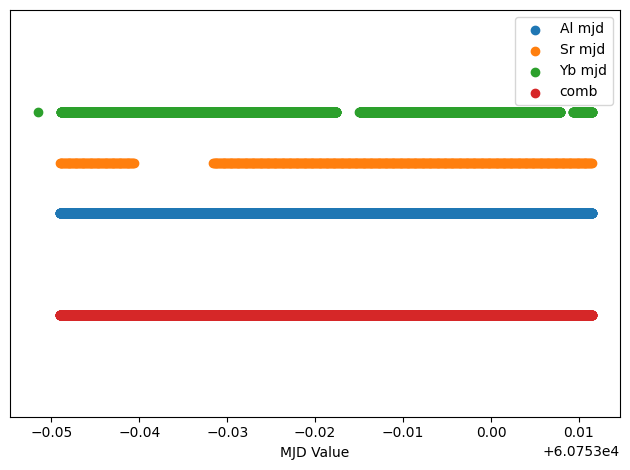

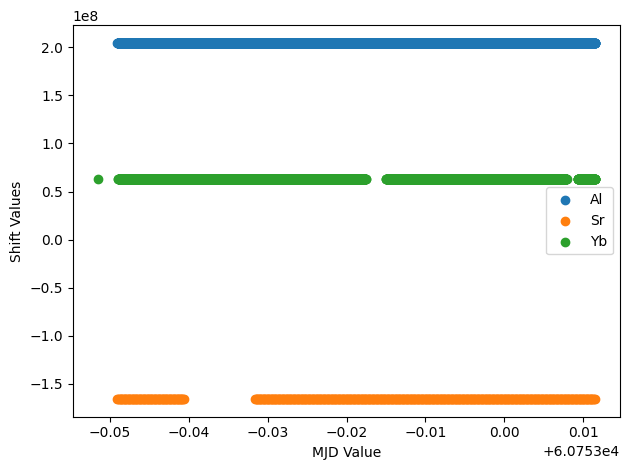

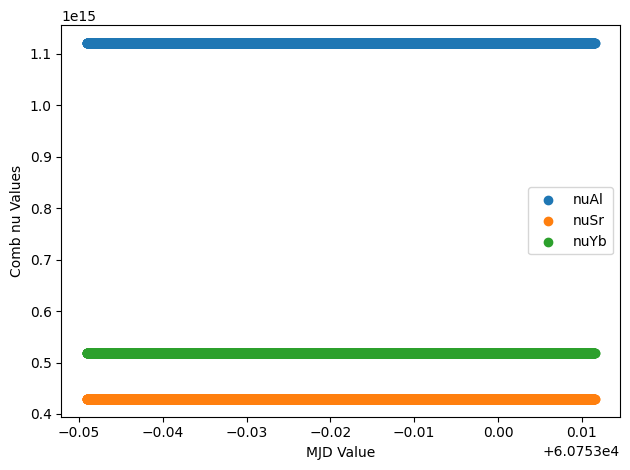

In [ ]:
## Visualize overlapping MJD values for subset data and missing shift values w/in this window of overlap

plt.figure()
plt.scatter(shift_data_Al['MJD'], pd.Series([1] * len(shift_data_Al['MJD'])), label = 'Al mjd')
plt.scatter(shift_data_Sr['MJD'], pd.Series([1.25] * len(shift_data_Sr['MJD'])), label = 'Sr mjd')
plt.scatter(shift_data_Yb['MJD'], pd.Series([1.5] * len(shift_data_Yb['MJD'])), label = 'Yb mjd')
plt.scatter(comb['MJD'], pd.Series([0.5] * len(comb['MJD'])), label = 'comb')
plt.ylim(0,2)
plt.yticks([])
plt.xlabel("MJD Value")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(shift_data_Al['MJD'], shift_data_Al['shift'], label = 'Al')
plt.scatter(shift_data_Sr['MJD'], shift_data_Sr['shift'], label = 'Sr')
plt.scatter(shift_data_Yb['MJD'], shift_data_Yb['shift'], label = 'Yb')
plt.xlabel("MJD Value")
plt.ylabel("Shift Values")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(comb['MJD'], comb['nuAl'], label = 'nuAl')
plt.scatter(comb['MJD'], comb['nuSr'], label = 'nuSr')
plt.scatter(comb['MJD'], comb['nuYb'], label = 'nuYb')
plt.xlabel("MJD Value")
plt.ylabel("Comb nu Values")
plt.legend()
plt.tight_layout()
plt.show()



## Interpolation


In [207]:
################################################################################
##############  Reformat Data for Interpolation  ###############################
################################################################################ 
## Data 
# the shift data frames are: shift_data_Al, shift_Data_Sr, and shift_data_Yb with columns: MJD, shift, is_good
# comb is dataframe with columns MJD, nuAl, nuSr, and nuYb

## Reformat all data so is indexed by datetime 
comb_datetime = comb.copy()
comb_datetime['datetime'] = Time(comb_datetime['MJD'], format = 'mjd').to_datetime()
comb_datetime = comb_datetime.set_index('datetime')

shift_data_Al_datetime = shift_data_Al.copy()
shift_data_Al_datetime['datetime'] = Time(shift_data_Al_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Al_datetime = shift_data_Al_datetime.set_index('datetime')

shift_data_Sr_datetime = shift_data_Sr.copy()
shift_data_Sr_datetime['datetime'] = Time(shift_data_Sr_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Sr_datetime = shift_data_Sr_datetime.set_index('datetime')

shift_data_Yb_datetime = shift_data_Yb.copy()
shift_data_Yb_datetime['datetime'] = Time(shift_data_Yb_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Yb_datetime = shift_data_Yb_datetime.set_index('datetime')

# Eliminate all columns except shift and keep datetime index
Al_shift = shift_data_Al_datetime['shift']
Sr_shift = shift_data_Sr_datetime['shift']
Yb_shift = shift_data_Yb_datetime['shift']

In [208]:
################################################################################
#############################  Interpolation  ##################################
################################################################################ 

interp_method = 'from_derivatives' #'time' 'linear' 'cubic' 

# these are indicies that comb has but Al shift file does not 
interp_times_Al = comb_datetime.index.difference(Al_shift.index) 
# this is the union with the original Al shift indices 
long_Al_index = Al_shift.index.union(interp_times_Al).sort_values()
# this is the expanded Al shift time series that includes NaNs for indicies only in comb data 
Al_shift_expanded = Al_shift.reindex(long_Al_index)
# interpolate the missing Al shift values 
Al_shift_interpolated = Al_shift_expanded.interpolate(method=interp_method, limit=10)
# extract the shift values corresponding to the datetime indicies of the comb data 
Al_shift_final = Al_shift_interpolated[comb_datetime.index]

interp_times_Sr = comb_datetime.index.difference(Sr_shift.index) 
long_Sr_index = Sr_shift.index.union(interp_times_Sr).sort_values()
Sr_shift_expanded = Sr_shift.reindex(long_Sr_index)
Sr_shift_interpolated = Sr_shift_expanded.interpolate(method=interp_method, limit=10)
Sr_shift_final = Sr_shift_interpolated[comb_datetime.index]

interp_times_Yb = comb_datetime.index.difference(Yb_shift.index) 
long_Yb_index = Yb_shift.index.union(interp_times_Yb).sort_values()
Yb_shift_expanded = Yb_shift.reindex(long_Yb_index)
Yb_shift_interpolated = Yb_shift_expanded.interpolate(method=interp_method, limit=10)
Yb_shift_final = Yb_shift_interpolated[comb_datetime.index]


In [210]:
################################################################################
###################### Final Data Processing Steps #############################
################################################################################ 

# change data type to high-precision Decimal
nuAl = [Decimal(i) for i in comb['nuAl']]
nuSr = [Decimal(i) for i in comb['nuSr']]
nuYb = [Decimal(i) for i in comb['nuYb']]
shiftAl = [Decimal(i) for i in Al_shift_final]
shiftSr = [Decimal(i) for i in Sr_shift_final]
shiftYb = [Decimal(i) for i in Yb_shift_final]

# add comb frequencies and clock shift files
frequency_Al_ErYb = [(i + j) * total_correction_Al for i,j in zip(nuAl, shiftAl)]
frequency_Sr_ErYb = [(i + j) * total_correction_Sr for i,j in zip(nuSr, shiftSr)]
frequency_Yb_ErYb = [(i + j) * total_correction_Sr for i,j in zip(nuYb, shiftYb)]

# convert lists contaiing series (of length one) into a single-Decimal-value series object so can apply avar function
frequency_Al_ErYb = [v.iloc[0] for v in frequency_Al_ErYb] 
frequency_Sr_ErYb = [v.iloc[0] for v in frequency_Sr_ErYb]
frequency_Yb_ErYb = [v.iloc[0] for v in frequency_Yb_ErYb]


Al+/Sr ratio offset from BACON paper -1.1812E-16
AVAR tau=5:  1.825049023630508704706257447E-33
AVAR tau=500:  5.360652006663802040414741103E-34
AVAR tau= 1406 :  6.238359139598838846307030592E-35


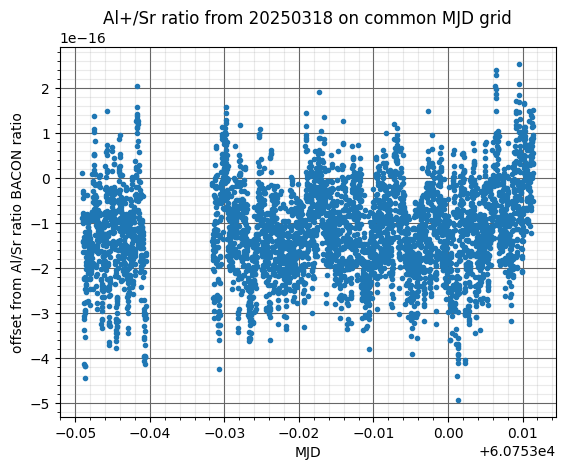

In [211]:
################################################################################
#######################  Plotting and Summarizing Ratios #######################
################################################################################
 
## Al/Sr ratio offset  
frequency_ratio_ErYb1 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Sr_ErYb)]

clean_frequency_ratio_ErYb1 = [
    x for x in frequency_ratio_ErYb1
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Al+/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, 500)) 
print("AVAR tau=", math.floor(len(clean_frequency_ratio_ErYb1)/3), ": ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, math.floor(len(clean_frequency_ratio_ErYb1)/3))) 


plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al+/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

Yb/Sr ratio offset from BACON paper 1.7685E-15
AVAR tau=5:  2.589180079232878381712305683E-33
AVAR tau=500:  3.986454139867255896722805632E-35
AVAR tau= 1284 :  5.294630292481755433902995943E-35


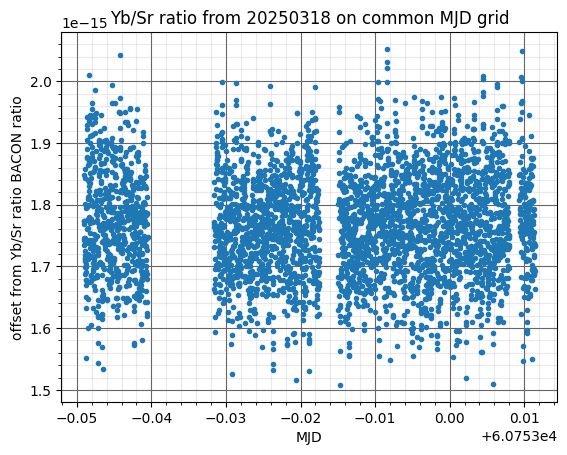

In [212]:
## Yb/Sr ratio offset  
frequency_ratio_ErYb2 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb, frequency_Sr_ErYb)]
 
clean_frequency_ratio_ErYb2 = [
    x for x in frequency_ratio_ErYb2
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Yb/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb2, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb2, 500)) 
print("AVAR tau=", math.floor(len(clean_frequency_ratio_ErYb2)/3), ": ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, math.floor(len(clean_frequency_ratio_ErYb2)/3))) 


plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

Al+/Yb ratio offset from BACON paper -1.8909E-15
AVAR tau=5:  2.645965014579538719074181137E-33
AVAR tau=500:  2.613668673343731201330179963E-34
AVAR tau= 1524 :  4.230645997970923862428848117E-35


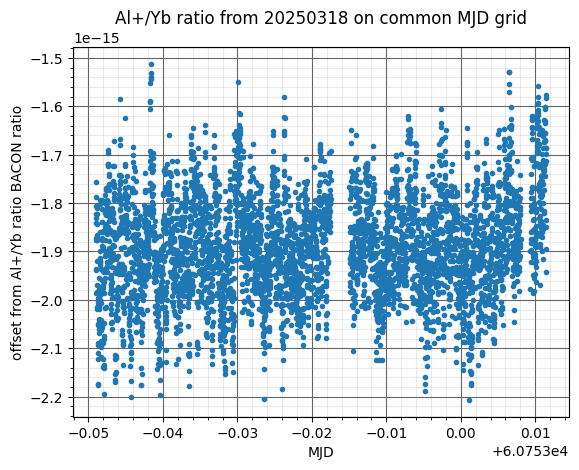

In [213]:
## Al/Yb ratio offset  
frequency_ratio_ErYb3 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Yb_ErYb)]
 
clean_frequency_ratio_ErYb3 = [
    x for x in frequency_ratio_ErYb3
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Al+/Yb ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb3, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb3, 500)) 
print("AVAR tau=", math.floor(len(clean_frequency_ratio_ErYb3)/3), ": ", overlapping_avar_fn(clean_frequency_ratio_ErYb3, math.floor(len(clean_frequency_ratio_ErYb1)/3))) 

plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al+/Yb ratio BACON ratio")
plt.title("Al+/Yb ratio from " + days[day_index] + " on common MJD grid")
plt.show()


In [214]:

## Approach 1) found in pandas_interpolation_nick.py - effectively only performs 1d linear interpolation to match shift data to comb MJD
## shift_Al_tmp = shift_data_Al["shift"].interpolate(method="linear")  ##note this step is not necessary b/c of earlier filtering out "bad" shift data 
## shift_Sr_tmp = shift_data_Sr["shift"].interpolate(method="linear")
## shift_Yb_tmp = shift_data_Yb["shift"].interpolate(method="linear")

# shiftAl = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_Al_tmp)
# shiftSr = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_Sr_tmp)
# shiftYb = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_Yb_tmp)


## Approach 2) same as above except there's an additional interpolation step for missing vales in the comb data file
# nuAl = nuAl.interpolate(method = 'linear', limit = 10) 
# nuSr = nuSr.interpolate(method = 'linear', limit = 10)
# nuYb = nuYb.interpolate(method = 'linear', limit = 10)

# shiftAl = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_data_Al["shift"])
# shiftSr = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_data_Sr["shift"])
# shiftYb = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_data_Yb["shift"])

# ## Approach 3) Time series specific interpolation


# ## Outer join all shift data w/ comb values along MJD values, creating date-time index  
# comb_al_subset = comb[['MJD', 'nuAl']]
# al_subset = shift_data_Al.drop(columns=['IS_GOOD'])
# al_merged = pd.merge(comb_al_subset, al_subset, on="MJD", how="outer")
# timesAl = Time(al_merged['MJD'].values, format='mjd')
# datetime_index_Al = pd.DatetimeIndex(timesAl.to_datetime())
# al_merged.index = datetime_index_Al

# comb_sr_subset = comb[['MJD', 'nuSr']]
# sr_subset = shift_data_Sr.drop(columns=['IS_GOOD'])
# sr_merged = pd.merge(comb_sr_subset, sr_subset, on="MJD", how="outer")
# timesSr = Time(sr_merged['MJD'].values, format='mjd')
# datetime_index_Sr = pd.DatetimeIndex(timesSr.to_datetime())
# sr_merged.index = datetime_index_Sr

# comb_yb_subset = comb[['MJD', 'nuYb']]
# yb_subset = shift_data_Yb.drop(columns=['IS_GOOD'])
# yb_merged = pd.merge(comb_yb_subset, yb_subset, on="MJD", how="outer")
# timesYb = Time(yb_merged['MJD'].values, format='mjd')
# datetime_index_Yb = pd.DatetimeIndex(timesYb.to_datetime())
# yb_merged.index = datetime_index_Yb

# method_comb = 'time'
# method_shift = 'time'

# nuAl = al_merged['nuAl'].interpolate(method=method_comb, limit=10)
# shiftAl = al_merged['shift'].interpolate(method=method_shift, limit=10)

# nuSr = sr_merged['nuSr'].interpolate(method=method_comb, limit=10)
# shiftSr = sr_merged['shift'].interpolate(method=method_shift, limit=10)

# nuYb = yb_merged['nuYb'].interpolate(method=method_comb, limit=10)
# shiftYb = yb_merged['shift'].interpolate(method=method_shift, limit=10)


## Approach 4 - interpolate all missing values before finding overlapping window and then aligning series 
# Interpolate missing comb data https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
# methods include: linear (which treats values as equally spaced), time (requires additional processing to datetime format), pad (depreciated use different function), nearest, polynomial (must specify an order) 
# nuAl = comb['nuAl'].interpolate(method = 'nearest') 
# nuSr = comb['nuSr'].interpolate(method = 'nearest')
# nuYb = comb['nuYb'].interpolate(method = 'nearest')
# Align shift data with comb MJD grid (Q - what happens w/ missing data?) https://numpy.org/doc/2.2/reference/generated/numpy.interp.html
# specifically helps w/ alignment b/c input requires coordinates at which to evaluate interpolated values, no method option (only linear) 
# scipy.interpolate.interp1d is an alternative that permits different methods (but no time based method) 
# To evaluate interpolated values at new time points using the "time" method in pandas, you should:
# 0. index all data frames w/ datetime object based on MJD values 
# 1. Combine the original time series and the new time points into a single DatetimeIndex.
# 2. Reindex the original data to include the new time points.
# 3. Use .interpolate(method="time") to fill the missing values — this will include the new time points.
# Step 0: 
# Step 1: Combine original and new times, Use difference() to exclude overlapping time points from the union
#   all_times = ts.index.union(new_times).sort_values()
# Step 2: Reindex the series
#   ts_reindexed = ts.reindex(all_times)
# Step 3: Interpolate using method='time'
#   ts_interp = ts_reindexed.interpolate(method='time')

# timesComb = Time(comb['MJD'].values, format='mjd')
# datetime_index_comb = pd.DatetimeIndex(timesComb.to_datetime())


# interp_times_Al = comb.index.difference(shift_data_Al_datetime.index)
# #print(interp_times_Al)
# #print(shift_data_Al_datetime.index)

# all_times_Al = shift_data_Al_datetime.index.union(interp_times_Al).sort_values()
# Al_reindexed = shift_data_Al_datetime.reindex(all_times_Al)
#Al_interp = Al_reindexed['shift'].interpolate(method='time')
#print(Al_interp)


